.\content\DATA\00048035\00048035.json
.\content\DATA\01142281\01142281.json
.\content\DATA\016047953\106047953.json
.\content\DATA\01990231\01990231.json
.\content\DATA\03158534\03158534.json
.\content\DATA\03877078\03877078.json
.\content\DATA\04886479\04886479.json
.\content\DATA\05609172\05609172.json
.\content\DATA\06280116\06280116.json
.\content\DATA\10874765\10874765.json
.\content\DATA\10929576\10929576.json
.\content\DATA\11830358\11830358.json
.\content\DATA\13549073\13549073.json
.\content\DATA\15144615\151446151.json


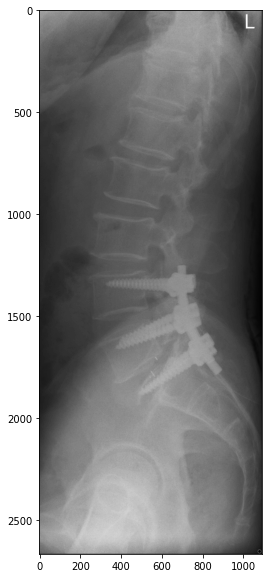

In [1]:
import os
import numpy as np
from PIL import Image
from MyLoad import MyLoadDATA
import matplotlib.pyplot as plt
import random

data = MyLoadDATA()
random_id = random.randint(0, len(data)-1)
img = Image.open(data[random_id]['filepath'])
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')

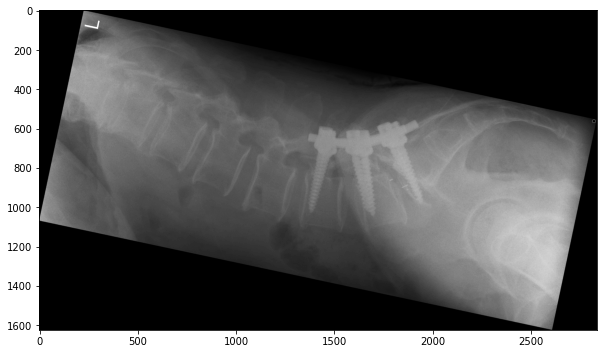

In [2]:
import torchvision.transforms.functional as TF

angle = 78
# angle = random.randint(-30,30)

rotate_img = TF.rotate(img, angle, expand=True)
plt.figure(figsize=(10,10))
plt.imshow(rotate_img, cmap='gray')

In [3]:
def rotate_point(origin, org_center, new_center, angle):

    ox, oy = origin
    cx, cy = org_center
    nx, ny = new_center

    r = np.sqrt((ox - cx)**2 + (oy-cy)**2)
    theta = np.arctan2( oy-cy , ox-cx)

    qx = nx + r * np.cos(theta-angle)
    qy = ny + r * np.sin(theta-angle)

    return qx, qy

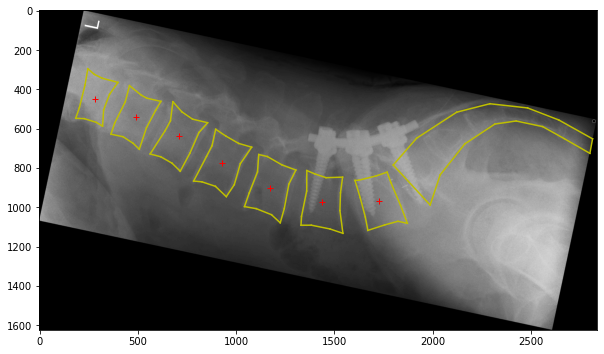

In [4]:
import math

rotate_img = TF.rotate(img, angle, expand=True)

x_labels = data[random_id]['x_label']
y_labels = data[random_id]['y_label']
position = data[random_id]['position']

mid_xs = [sum(x_labels[k])/len(x_labels[k]) for k in range(len(x_labels)) if position[k] != 'S']
mid_ys = [sum(y_labels[k])/len(y_labels[k]) for k in range(len(x_labels)) if position[k] != 'S']

# rotate the coordinate with fixed center point
# cartesian => ploar => add rotate angle => cartesian

org_center_x, org_center_y = img.size
org_center_x = int(org_center_x / 2)
org_center_y = int(org_center_y / 2)

new_center_x, new_center_y = rotate_img.size
new_center_x = int(new_center_x / 2)
new_center_y = int(new_center_y / 2)

transform_mid = []
for mid_x, mid_y in zip(mid_xs, mid_ys):
    transform_mid.append((rotate_point((mid_x, mid_y), (org_center_x, org_center_y), (new_center_x,new_center_y), math.radians(angle))))

plt.figure(figsize=(10,10))
plt.imshow(rotate_img, cmap='gray')

for mid_x, mid_y in transform_mid:
    plt.plot(mid_x, mid_y, 'r+')
for x_label, y_label in zip(x_labels, y_labels):
    for idx in range(len(x_label)):
        x1, y1 = rotate_point((x_label[idx], y_label[idx]), (org_center_x, org_center_y), (new_center_x,new_center_y), math.radians(angle))
        x2, y2 = rotate_point((x_label[idx + 1 if idx + 1 < len(x_label) else 0], y_label[idx + 1 if idx + 1 < len(x_label) else 0]), (org_center_x, org_center_y), (new_center_x,new_center_y), math.radians(angle))
        
        plt.plot([x1, x2], [y1, y2], '-y')

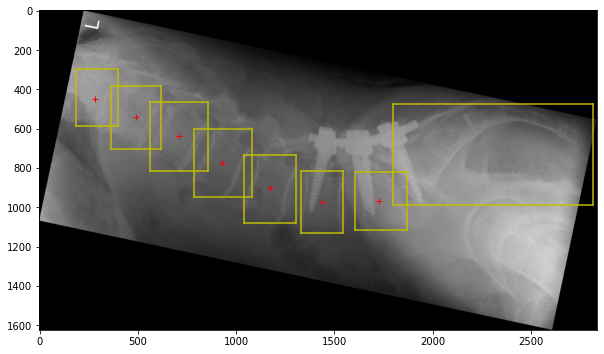

In [5]:
transform_box = [] # (xmin xmax ymin ymax)

for x_label, y_label in zip(x_labels, y_labels):

    tempx = []
    tempy = []

    for idx in range(len(x_label)):
        trans_x, trans_y = rotate_point((x_label[idx], y_label[idx]), (org_center_x, org_center_y), (new_center_x,new_center_y), math.radians(angle))
        
        tempx.append(trans_x)
        tempy.append(trans_y)
    
    transform_box.append((min(tempx), max(tempx), min(tempy), max(tempy)))


plt.figure(figsize=(10,10))
plt.imshow(rotate_img, cmap='gray')

for mid_x, mid_y in transform_mid:
    plt.plot(mid_x, mid_y, 'r+')

for transform_label in transform_box:
    x_min, x_max, y_min, y_max = transform_label

    plt.plot([x_min, x_min], [y_min, y_max], '-y')
    plt.plot([x_max, x_max], [y_min, y_max], '-y')
    plt.plot([x_min, x_max], [y_min, y_min], '-y')
    plt.plot([x_min, x_max], [y_max, y_max], '-y')    

In [6]:
import json
import shutil

# random pick 40 images in DATA to rotate
# output images saved to DATA/Transform

# pseudo_json file could work with loadfile.ipynb,
# but can't actually work with VGG annotator

# random degree from -30 to 90 degree (counter clockwise)

random_sample_ids = random.sample(range(len(data)), k=50)

transform_dataset = []
transform_filepath = './content/DATA/Transform'
pseudo_joson = {'_via_img_metadata': dict()}
pseudo_joson_filepath = './content/DATA/Transform/Transform.json'

if os.path.exists(transform_filepath):
    shutil.rmtree(transform_filepath)
os.mkdir(transform_filepath)

for idx, random_sample_id in enumerate(random_sample_ids):
    
    curr_data = data[random_sample_id]
    
    org_img = Image.open(curr_data['filepath'])
    org_center_x, org_center_y = org_img.size
    org_center = (org_center_x/2, org_center_y/2)
    
    random_angle = random.randint(-30, 90)

    rotate_img = TF.rotate(org_img, random_angle, center=org_center, expand=True)
    new_center_x, new_center_y = rotate_img.size
    new_center = (new_center_x/2, new_center_y/2)

    rotate_filename = 'Transform_FILE'+str(idx)+'.bmp'
    rotate_img.save(os.path.join(transform_filepath, rotate_filename))

    curr_data_dict = dict()

    trans_x_labels = []
    trans_y_labels = []

    curr_data_dict['regions'] = []

    for org_x_label, org_y_label, vtype, vposition in zip(curr_data['x_label'], curr_data['y_label'], curr_data['type'], curr_data['position']):

        trans_x_label = []
        trans_y_label = []

        for org_x, org_y in zip(org_x_label, org_y_label):

            trans_x, trans_y = rotate_point((org_x, org_y), org_center, new_center, math.radians(random_angle))
            trans_x_label.append(int(trans_x))
            trans_y_label.append(int(trans_y))

        temp_dict = dict()
        temp_dict['shape_attributes'] = dict()
        temp_dict['region_attributes'] = dict()
        temp_dict['shape_attributes']['all_points_x'] = trans_x_label
        temp_dict['shape_attributes']['all_points_y'] = trans_y_label
        temp_dict['region_attributes']['type'] = vtype
        temp_dict['region_attributes']['position'] = vposition

        curr_data_dict['regions'].append(temp_dict)

    curr_data_dict['filename'] = rotate_filename
    curr_data_dict['filepath'] = os.path.join(transform_filepath, rotate_filename)
    
    pseudo_joson['_via_img_metadata'][rotate_filename] = curr_data_dict

with open(pseudo_joson_filepath, mode='w', encoding='utf-8') as f:
    json.dump(pseudo_joson, f)
